In [11]:
# ==========================
# ACCURACY (AVG) — LOAD + PLOT
# ==========================
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# ---------- CONFIG ----------
ACC_CFG = {
    "ROOT": Path("."),

    # where to find eval files
    "EVAL_NAME": "eval.json",

    # KD groups (5 runs each)
    "KD_GROUPS": {
        "FEATURE":   [f"FEATURE/MODEL {i}" for i in range(1, 6)],
        "RESPONSE":  [f"RESPONSE/MODEL {i}" for i in range(1, 6)],
        "RELATION":  [f"RELATION/MODEL {i}" for i in range(1, 6)],
    },

    # Baselines (single run each)
    "BASELINES": {
        "Traditional Student": "TRADITIONAL STUDENT",
        "Base / Teacher":      "BASE/TEACHER",
        "Base / Student":      "BASE/STUDENT",
    },

    # plotting order
    "ORDER": [
        "Base / Teacher",
        "Base / Student",
        "Traditional Student",
        "FEATURE",
        "RESPONSE",
        "RELATION",
    ],

    # colors (edit freely)
    "COLORS": {
        "Base / Teacher":      "#1f77b4",
        "Base / Student":      "#ff7f0e",
        "Traditional Student": "#2ca02c",
        "FEATURE":             "#4e79a7",
        "RESPONSE":            "#59a14f",
        "RELATION":            "#edc949",
    },

    # metric preference inside each task block
    # we'll try acc_norm_none first, then acc_none
    "METRIC_KEYS": ["acc_norm_none", "acc_none", "acc_norm,none", "acc,none"],


    # plot look
    "FIGSIZE": (7.5, 4.2),
    "DPI": 300,
    "YLIM": None,           # e.g. (0.0, 1.0) or (0.15, 0.35)
    "SHOW_STD": True,       # errorbars for KD groups
    "SAVE": True,
    "OUTDIR": Path("figures"),
    "BASENAME": "kd_accuracy_avg",
}


In [12]:
# ---------- ACC PARSER ----------
def extract_avg_accuracy_from_eval(eval_path: Path, metric_keys) -> float:
    """
    Supports both:
      A) flat schema: {task: {acc_*: ...}, ...}
      B) lm-eval schema: {"results": {task: {...}}, ...}

    Returns mean accuracy over tasks, using metric_keys in priority order.
    """
    obj = json.loads(eval_path.read_text(encoding="utf-8"))

    # Handle lm-eval harness wrapper
    task_dict = obj.get("results", obj)

    vals = []

    for task_name, task_block in task_dict.items():
        if not isinstance(task_block, dict):
            continue

        found = None

        # Try preferred keys first
        for k in metric_keys:
            if k in task_block and task_block[k] is not None:
                found = float(task_block[k])
                break

        # Common fallback keys (just in case)
        if found is None:
            for k in ["acc", "accuracy", "exact_match", "em"]:
                if k in task_block and task_block[k] is not None:
                    found = float(task_block[k])
                    break

        if found is not None:
            vals.append(found)

    if not vals:
        # Show metric keys from one example task to debug fast
        example_task_keys = []
        for _, tb in task_dict.items():
            if isinstance(tb, dict):
                example_task_keys = list(tb.keys())[:25]
                break

        raise KeyError(
            f"No accuracy metric found in {eval_path}.\n"
            f"Tried metric keys: {metric_keys} (+ common fallbacks).\n"
            f"Example task keys: {example_task_keys}"
        )

    return float(np.mean(vals))


def load_group_accuracies(root: Path, subpaths: list[str], eval_name: str, metric_keys) -> np.ndarray:
    accs = []
    for sp in subpaths:
        p = root / sp / eval_name
        if not p.exists():
            raise FileNotFoundError(f"Missing eval file: {p}")
        accs.append(extract_avg_accuracy_from_eval(p, metric_keys))
    return np.array(accs, dtype=float)


In [13]:
# ---------- BUILD SUMMARY TABLE ----------
def build_accuracy_summary(cfg: dict) -> pd.DataFrame:
    root = cfg["ROOT"]
    eval_name = cfg["EVAL_NAME"]
    metric_keys = cfg["METRIC_KEYS"]

    rows = []

    # baselines (single)
    for label, folder in cfg["BASELINES"].items():
        p = root / folder / eval_name
        if not p.exists():
            raise FileNotFoundError(f"Missing eval file: {p}")
        v = extract_avg_accuracy_from_eval(p, metric_keys)
        rows.append({"Category": label, "mean": v, "std": 0.0, "n": 1})

    # KD groups (5 runs)
    for kd, paths in cfg["KD_GROUPS"].items():
        arr = load_group_accuracies(root, paths, eval_name, metric_keys)
        rows.append({"Category": kd, "mean": float(arr.mean()), "std": float(arr.std()), "n": int(arr.size)})

    df = pd.DataFrame(rows)

    # enforce order
    order = cfg["ORDER"]
    df["Category"] = pd.Categorical(df["Category"], categories=order, ordered=True)
    df = df.sort_values("Category").reset_index(drop=True)

    return df


acc_df = build_accuracy_summary(ACC_CFG)
acc_df


,Category,mean,std,n
0,Base / Teacher,0.794155,0.000000,1
1,Base / Student,0.681143,0.000000,1
2,Traditional Student,0.677436,0.000000,1
3,FEATURE,0.249895,0.005171,5
4,RESPONSE,0.636377,0.004432,5
5,RELATION,0.644412,0.003681,5


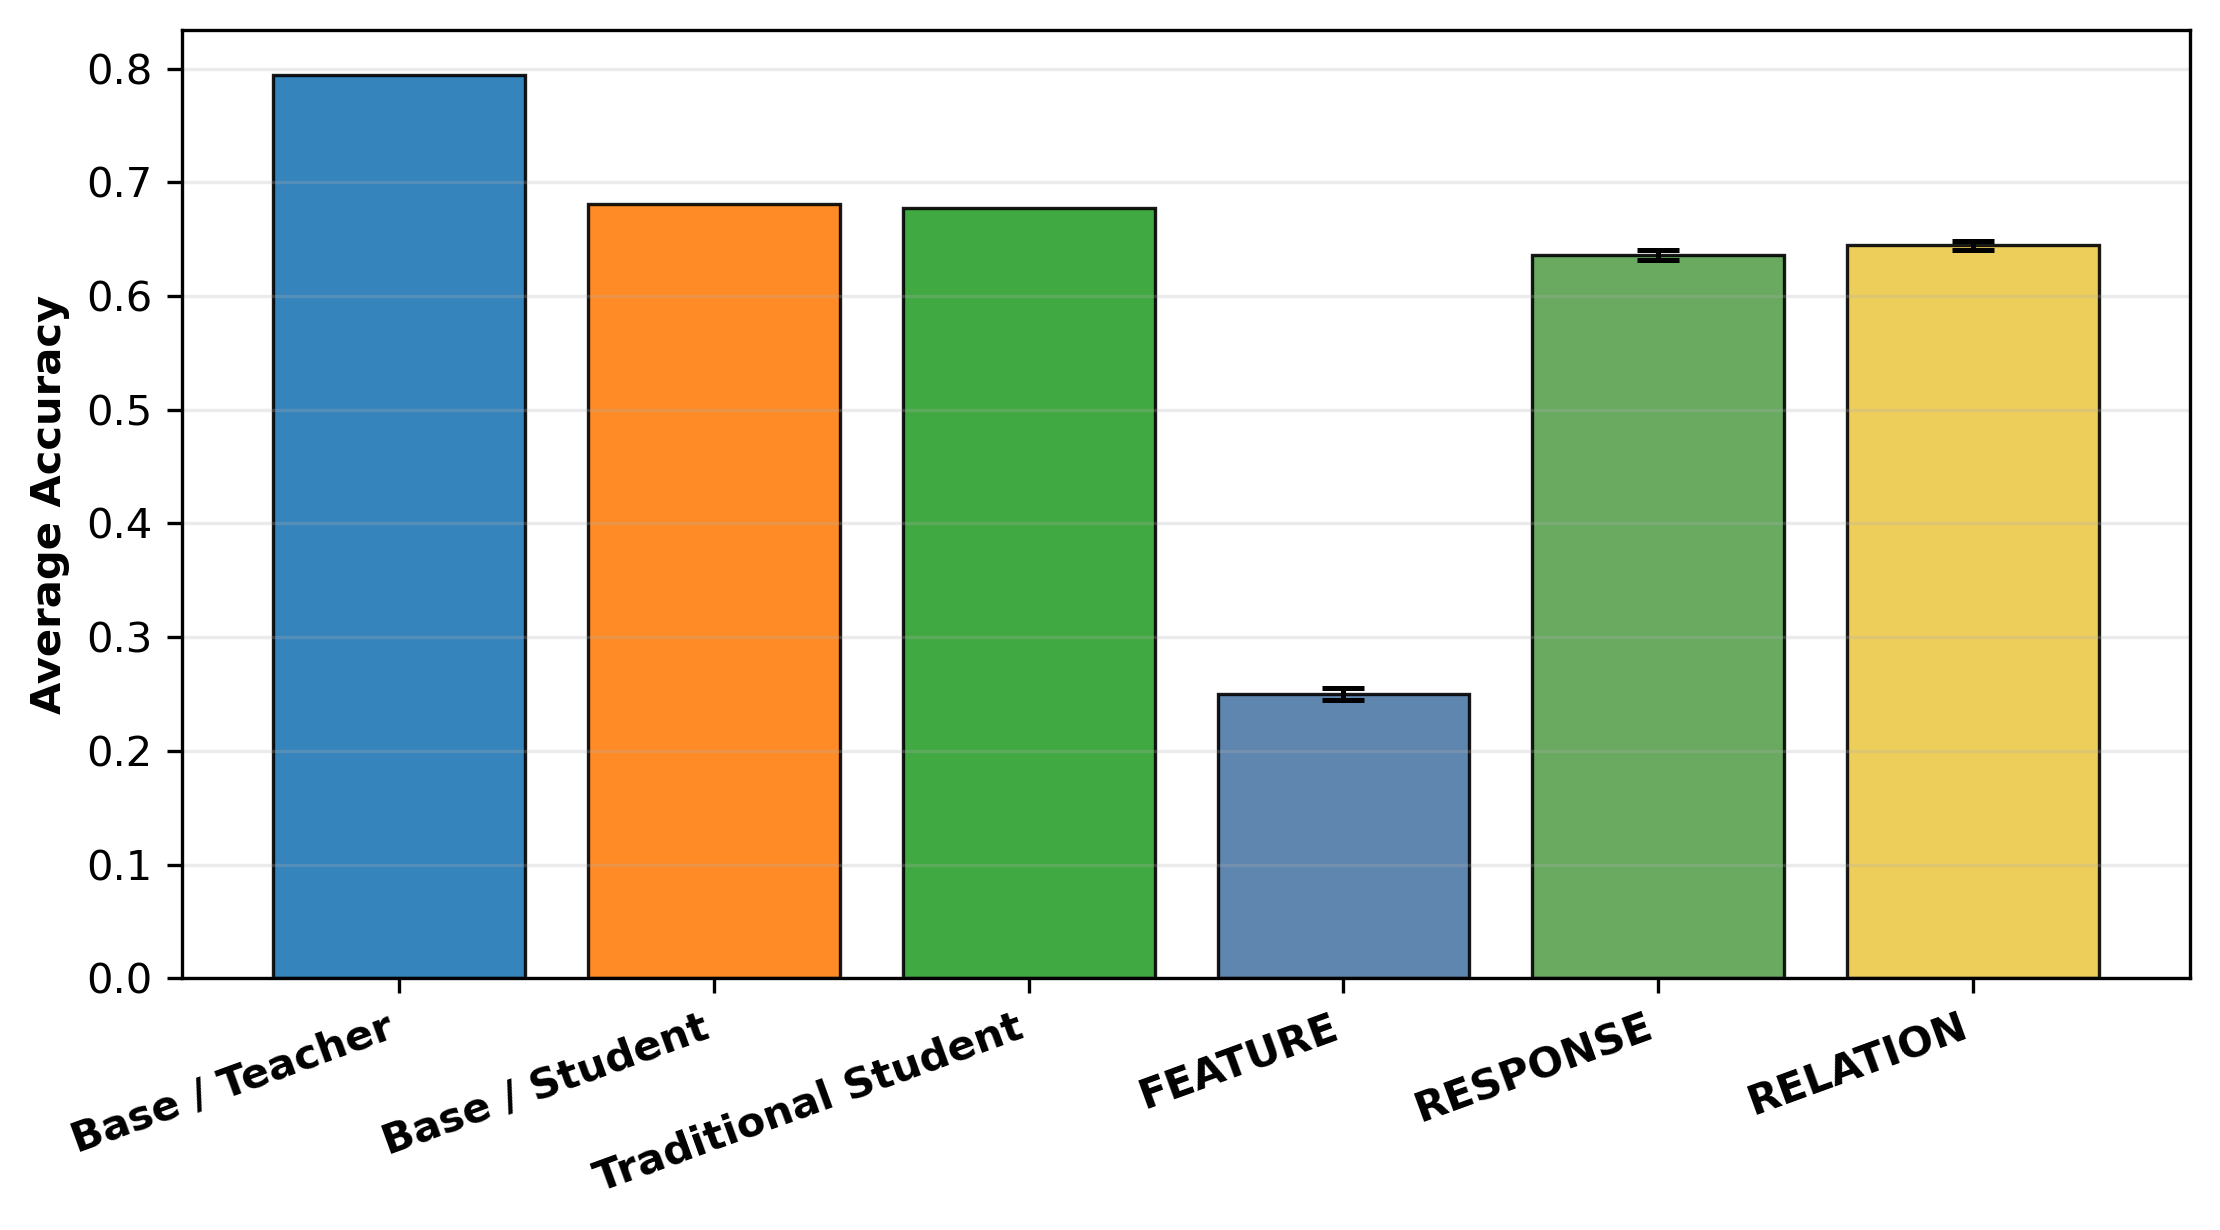

In [15]:
# ---------- PLOT ----------
def plot_avg_accuracy(acc_df: pd.DataFrame, cfg: dict):
    fig, ax = plt.subplots(figsize=cfg["FIGSIZE"], dpi=cfg["DPI"])

    x = np.arange(len(acc_df))
    means = acc_df["mean"].to_numpy()
    stds  = acc_df["std"].to_numpy()

    colors = [cfg["COLORS"].get(c, "gray") for c in acc_df["Category"].astype(str)]

    # bars
    ax.bar(x, means, color=colors, edgecolor="black", linewidth=0.8, alpha=0.9)

    # error bars only where std > 0 (KD groups)
    if cfg["SHOW_STD"]:
        mask = stds > 0
        ax.errorbar(
            x[mask], means[mask], yerr=stds[mask],
            fmt="none", ecolor="black", elinewidth=1.2, capsize=5, capthick=1.2
        )

    ax.set_xticks(x)
    ax.set_xticklabels(acc_df["Category"].astype(str), rotation=20, ha="right", fontweight="bold")
    ax.set_ylabel("Average Accuracy", fontweight="bold")
    ax.grid(True, axis="y", alpha=0.25)

    if cfg["YLIM"] is not None:
        ax.set_ylim(*cfg["YLIM"])

    # annotate n
    # for i, (m, n) in enumerate(zip(means, acc_df["n"].to_numpy())):
    #     ax.text(i, m, f"n={int(n)}", ha="center", va="bottom", fontsize=9, fontweight="bold")

    fig.tight_layout()

    if cfg["SAVE"]:
        cfg["OUTDIR"].mkdir(parents=True, exist_ok=True)
        fig.savefig(cfg["OUTDIR"] / f"{cfg['BASENAME']}.pdf", bbox_inches="tight")
        fig.savefig(cfg["OUTDIR"] / f"{cfg['BASENAME']}.svg", bbox_inches="tight")

    return fig, ax


fig, ax = plot_avg_accuracy(acc_df, ACC_CFG)
plt.show()


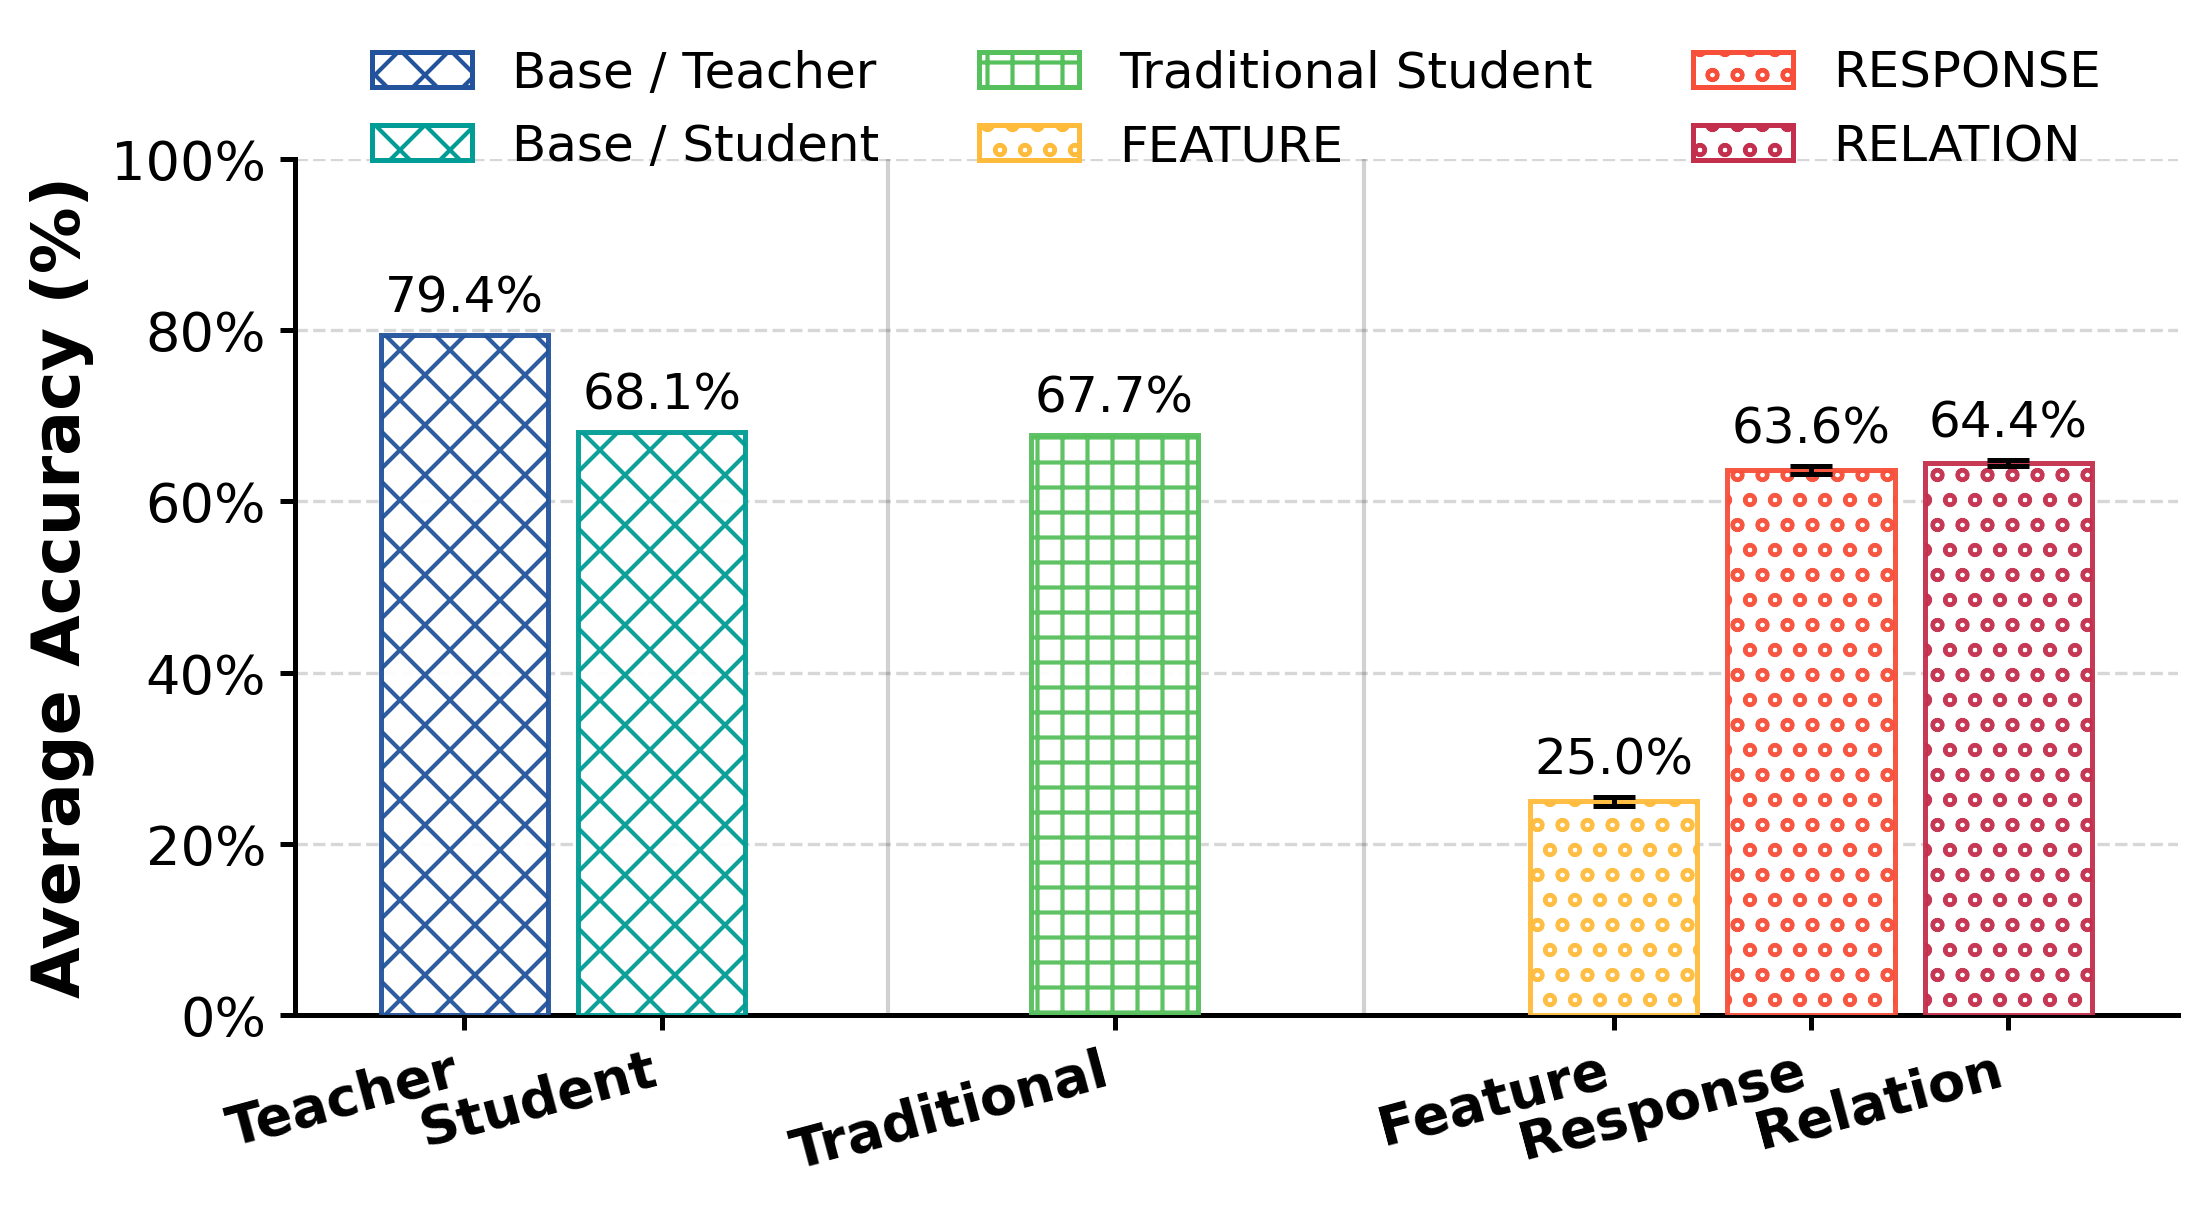

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from pathlib import Path
from matplotlib.ticker import FuncFormatter

matplotlib.rcParams["pdf.fonttype"] = 42  # publisher friendly


def plot_accuracy_hatched_style(acc_df, cfg):
    """
    Hatched accuracy bars with 3 visual groups:
      (Base / Teacher, Base / Student) | (Traditional Student) | (FEATURE, RESPONSE, RELATION)

    - Values shown as % (0–100)
    - Error bars only for KD (std > 0)
    - Numeric labels on top of bars
    - Top legend with hatch samples
    """
    df = acc_df.copy()
    df["Category"] = df["Category"].astype(str)

    # ---- Force our desired plotting order (3 groups) ----
    base_labels = ["Base / Teacher", "Base / Student"]
    trad_labels = ["Traditional Student"]
    kd_labels   = ["FEATURE", "RESPONSE", "RELATION"]
    labels = base_labels + trad_labels + kd_labels

    df = df.set_index("Category").reindex(labels).reset_index()

    means = df["mean"].to_numpy(dtype=float) * 100.0
    stds  = df["std"].to_numpy(dtype=float) * 100.0

    # ---- Style knobs ----
    bar_width  = 0.72
    within_gap = 0.85   # closer inside Base and KD groups
    solo_gap   = 1.10   # gap Base -> Traditional
    group_gap  = 1.30   # gap Traditional -> KD

    STYLE = {
        "Base / Teacher":      {"face": "#ffffff", "edge": "#23539c", "hatch": "xx"},
        "Base / Student":      {"face": "#ffffff", "edge": "#009c95", "hatch": "xx"},
        "Traditional Student": {"face": "#ffffff", "edge": "#56c05d", "hatch": "++"},
        "FEATURE":             {"face": "#ffffff", "edge": "#ffbb3b", "hatch": "oo"},
        "RESPONSE":            {"face": "#ffffff", "edge": "#f74f39", "hatch": "oo"},
        "RELATION":            {"face": "#ffffff", "edge": "#c42f4d", "hatch": "oo"},
    }

    # ---- Grouped x positions: Base | Traditional | KD ----
    x_pos = []
    x = 0.0

    for _ in base_labels:
        x_pos.append(x)
        x += within_gap

    x += solo_gap  # move to Traditional (solo)
    for _ in trad_labels:
        x_pos.append(x)
        x += within_gap

    x += group_gap  # move to KD group
    for _ in kd_labels:
        x_pos.append(x)
        x += within_gap

    x_pos = np.array(x_pos)

    # ---- Plot ----
    fig, ax = plt.subplots(figsize=cfg["FIGSIZE"], dpi=cfg["DPI"])

    for i, cat in enumerate(labels):
        st = STYLE.get(cat, {"face": "#f2f2f2", "edge": "gray", "hatch": ""})

        ax.bar(
            x_pos[i], means[i],
            width=bar_width,
            facecolor=st["face"],
            edgecolor=st["edge"],
            linewidth=1.2,
            hatch=st["hatch"],
            alpha=0.95,
            zorder=3,
        )

        # errorbars only if std > 0 (KD groups)
        if cfg["SHOW_STD"] and stds[i] > 0:
            ax.errorbar(
                x_pos[i], means[i], yerr=stds[i],
                fmt="none",
                ecolor="black",
                elinewidth=1.2,
                capsize=5,
                capthick=1.2,
                zorder=4,
            )

        # value label on top (accounts for errorbar height)
        label_y = means[i] + (stds[i] if stds[i] > 0 else 0) + 1.5
        ax.text(
            x_pos[i],
            label_y,
            f"{means[i]:.1f}%",
            ha="center",
            va="bottom",
            fontsize=12,
            fontweight="regular",
            zorder=5,
        )

    # ---- Axes styling ----
    ax.set_xticks(x_pos)
    ax.set_xticklabels(
        ["Teacher", "Student", "Traditional", "Feature", "Response", "Relation"],
        fontsize=13,
        fontweight="bold",
        rotation=15,
        ha="right",
    )

    ax.set_ylabel("Average Accuracy (%)", fontsize=16, fontweight="bold")
    ax.set_ylim(0, 100)
    ax.yaxis.set_major_formatter(FuncFormatter(lambda v, _: f"{int(v)}%"))

    ax.grid(axis="y", linestyle="--", alpha=0.5, zorder=0)
    ax.xaxis.grid(False)
    ax.set_axisbelow(True)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_linewidth(1.2)
    ax.spines["bottom"].set_linewidth(1.2)

    ax.tick_params(axis="y", labelsize=13, width=1.2)
    ax.tick_params(axis="x", labelsize=13, width=1.2)

    # Optional faint dividers between groups
    ax.axvline((x_pos[1] + x_pos[2]) / 2, color="black", linewidth=1.0, alpha=0.18)
    ax.axvline((x_pos[2] + x_pos[3]) / 2, color="black", linewidth=1.0, alpha=0.18)

    # ---- Legend at top ----
    legend_handles = []
    legend_labels = []
    for cat in labels:
        st = STYLE.get(cat, {"face": "#f2f2f2", "edge": "gray", "hatch": ""})
        legend_handles.append(
            plt.Rectangle((0, 0), 1, 1,
                          facecolor=st["face"],
                          edgecolor=st["edge"],
                          hatch=st["hatch"],
                          linewidth=1.2)
        )
        legend_labels.append(cat)

    ax.legend(
        legend_handles,
        legend_labels,
        loc="upper center",
        bbox_to_anchor=(0.5, 1.18),
        ncol=3,
        frameon=False,
        fontsize=12,
    )

    fig.tight_layout()

    if cfg["SAVE"]:
        outdir = Path(cfg["OUTDIR"])
        outdir.mkdir(parents=True, exist_ok=True)
        fig.savefig(outdir / f"{cfg['BASENAME']}_hatched.pdf", bbox_inches="tight")
        fig.savefig(outdir / f"{cfg['BASENAME']}_hatched.svg", bbox_inches="tight")

    return fig, ax


# Usage:
fig, ax = plot_accuracy_hatched_style(acc_df, ACC_CFG)
plt.show()
